# Analysis of models result

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import math
from scipy import signal

%matplotlib inline  

path_mAP = '../mAP/ground-truth/'
path_models = '../mAP/Modelos Testados/'
path_fps = '../Modelos.csv'

trashhold_FPS = 3

plt.figure(figsize=(12,7));

<Figure size 864x504 with 0 Axes>

# Functions

In [2]:
def plot_side_bar(df,x_column,y_column, title,size = (12,7), format_numb="{:.2f}%"):
    ax = results.sort_values(y_column).plot(x = x_column, y = [y_column], figsize=size, kind='barh')
    x_offset = 1
    y_offset = -0.3
    for p in ax.patches:
        b = p.get_bbox()
        val = format_numb.format(b.x1 + b.x0)        
        ax.annotate(val, ((b.x0 + b.x1) + x_offset, b.y1 + y_offset))
    ax.set_xlim(0, 100)
    ax.set_title(title)
    ax.set_ylabel(None)
    plt.show()
    
    
def plot_counter(predict, predict_name, real, x_column, y_column, size = (15,7)):
    if(not type(y_column) == tuple):
        y_column = (y_column,y_column)
    if(not type(x_column) == tuple):
        x_column = (x_column,x_column)
        
    plt.figure(figsize=size)

    plt.plot(predict.set_index(x_column[0])[[y_column[0]]], label = predict_name)
    plt.plot(real.set_index(x_column[1])[[y_column[1]]], label = 'Ground Truth')

    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
         mode="expand", borderaxespad=0.)
    
    plt.xlabel('Frames')
    plt.ylabel('Count')
    
    plt.show()
    
def get_error(predict, predict_col, real, real_col):
    count_error = predict.join(real.set_index('frame_number'), on='frame_number', rsuffix='_true')
    #count = count.drop('model_name_true', 1)

    count_error['error'] = np.absolute(np.subtract(count_error[predict_col],count_error[real_col+'_true']))
    
    return count_error['error']

def get_perc_error(predict, predict_col, real, real_col):
    count_error = predict.join(real.set_index('frame_number'), on='frame_number', rsuffix='_true')
    #count = count.drop('model_name_true', 1)

    count_error['error_p'] = abs(count_error[predict_col] - count_error[real_col+'_true'])
    count_error['error_p'] = count_error['error_p']/count_error[real_col+'_true']
    
    return count_error['error_p']

def scatter_plot(df, models_names, x_column, y_column, figsize=(15,7), x_label = ' ', y_label = ' '):
    plt.figure(figsize=figsize) 
    for model in models_names:
        to_print = df[df['model_name']==model]
        plt.scatter(to_print[x_column],to_print[y_column])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(models_names)
    plt.show()
    
def plot_freq(df, column):
    sp = abs(np.fft.fft(df[column]))
    freq = np.fft.fftfreq(df['frame_number'].shape[-1])

    indexs_freq = np.where(freq > 0)[0] #Remove negative values

    sp = sp[indexs_freq]
    freq = freq[indexs_freq]

    plt.figure(figsize=(12,7))
    plt.plot(freq, sp)
    plt.xlabel('w')
    plt.ylabel('|H(w)|')
    plt.show()
    
def plot_freq_diff(df_real, df, column_real, column):
    sp = abs(abs(np.fft.fft(df_real[column_real])) - abs(np.fft.fft(df[column])))

    freq = np.fft.fftfreq(df['frame_number'].shape[-1])

    indexs_freq = np.where(freq > 0)[0] #Remove negative values

    sp = sp[indexs_freq]
    freq = freq[indexs_freq]

    plt.figure(figsize=(12,7))
    plt.plot(freq, sp)
    plt.xlabel('w')
    plt.ylabel('Error |H(w)|')
    plt.show()

# Import Ground Truth

In [3]:
frames_files = os.listdir(path_mAP)
to_concat =[]
for frame_file in frames_files:
    frame_n = int( frame_file.split('_')[1].split('.')[0] )

    df = pd.read_csv(path_mAP + frame_file,  sep = ' ', header=None)
    df.loc[:,df.shape[1]] = frame_n
    df.loc[:,df.shape[1]] = 'Ground Truth'
    df.columns = ['class_name','left', 'top', 'right', 'bottom', 'frame_number','model_name']
    to_concat.append(df)

ground_truth = pd.concat(to_concat).sort_values('frame_number')
del(df, frame_file, frames_files, to_concat)

ground_truth.head()

,class_name,left,top,right,bottom,frame_number,model_name
0,person,499.0,158.0,530.030,233.170,1,Ground Truth
1,person,258.0,219.0,290.913,307.702,1,Ground Truth
2,person,633.0,242.0,675.338,323.074,1,Ground Truth
0,person,497.0,158.0,528.030,233.170,2,Ground Truth
1,person,263.0,218.0,295.774,306.505,2,Ground Truth


# Import models predictions

In [4]:
models_names = os.listdir(path_models)
print('Included Models: ')
[print('\t' + model) for model in models_names];

Included Models: 
	faster_rcnn_inception_v2_coco
	yolov3
	ssd_mobilenet_v1_coco
	ssd_mobilenet_v2_coco
	ssd_inception_v2_coco
	ssdlite_mobilenet_v2_coco
	ssd_mobilenet_v1_0.75_depth_coco
	ssd_mobilenet_docker
	ssd_mobilenet_v1_ppn_coco
	yolov3_tiny


In [5]:
to_concat_m = []

for model in models_names:
    predicteds = os.listdir(path_models + model + '/' + 'predicted')
    
    to_concat =[]
    for predicted in predicteds:
        frame_n = int( predicted.split('_')[1].split('.')[0] )

        df = pd.read_csv(path_models + model + '/' + 'predicted/' + predicted,  sep = ' ', header=None)
        df.loc[:,df.shape[1]] = frame_n
        df.loc[:,df.shape[1]] = model
        df.columns = ['class_name', 'confidence','left', 'top', 'right', 'bottom', 'frame_number','model_name']
        to_concat.append(df)
        
    print(model+' Loaded')
    df = pd.concat(to_concat).sort_values('frame_number')
    to_concat_m.append(df)

models_prediteds = pd.concat(to_concat_m).reset_index(drop=True)

del(df, model, predicted, predicteds, to_concat, to_concat_m)
models_prediteds.sample(5)

faster_rcnn_inception_v2_coco Loaded
yolov3 Loaded
ssd_mobilenet_v1_coco Loaded
ssd_mobilenet_v2_coco Loaded
ssd_inception_v2_coco Loaded
ssdlite_mobilenet_v2_coco Loaded
ssd_mobilenet_v1_0.75_depth_coco Loaded
ssd_mobilenet_docker Loaded
ssd_mobilenet_v1_ppn_coco Loaded
yolov3_tiny Loaded


,class_name,confidence,left,top,right,bottom,frame_number,model_name
3474,person,0.992010,254.969925,433.265213,304.538498,574.071178,594.0,faster_rcnn_inception_v2_coco
31691,person,0.825103,695.878922,101.614360,713.743698,152.103773,203.0,ssd_mobilenet_docker
39835,person,0.562373,628.000000,144.000000,643.000000,178.000000,173.0,yolov3_tiny
16428,person,0.589147,484.175720,141.303998,507.129364,190.164894,703.0,ssd_mobilenet_v2_coco
22864,person,0.519171,572.342926,152.184282,597.028931,214.610315,392.0,ssdlite_mobilenet_v2_coco


# Import models results

In [6]:
to_concat_m = []

for model in models_names:
    
    dic_model = {'model_name': model}
    with open(path_models + model + '/results/results.txt') as f:
        person_AP_found = 0
        
        for line in f:
            #find mAP
            find = re.search("(\w+?)*person AP", line)
            if(find):
                if(not person_AP_found):
                    person_AP_found = 1
                    dic_model['mAP'] = float(line.split('%')[0])
            
            #find TP
            find = re.search("(\w+?)*tp", line)
            if(find):
                dic_model['true_positive'] = int(line.split(':')[2].split(',')[0])  #get TP
                dic_model['false_positive'] = int(line.split(':')[3].split(')')[0]) #get FP 
                dic_model['found'] = int(line.split(':')[1].split('(')[0].strip()) #get Total
    
    df = pd.DataFrame(dic_model, index=[0])
    to_concat_m.append(df)

results = pd.concat(to_concat_m).reset_index(drop=True)

del(to_concat_m, dic_model, df, find, person_AP_found)

fps = pd.fps = pd.read_csv(path_fps)[['Model', 'FPS']]
fps.columns = ['model_name', 'fps']
fps = fps[fps['fps'] >= 0.5]
results = results.join(fps.set_index('model_name'), 'model_name')

results

,model_name,mAP,true_positive,false_positive,found,fps
0,faster_rcnn_inception_v2_coco,80.34,4015,855,4870,0.993388
1,yolov3,78.62,4017,777,4794,0.900000
2,ssd_mobilenet_v1_coco,53.56,2847,622,3469,12.194021
3,ssd_mobilenet_v2_coco,61.20,3240,574,3814,9.074642
4,ssd_inception_v2_coco,64.76,3318,567,3885,5.689048
5,ssdlite_mobilenet_v2_coco,60.26,3236,725,3961,12.410751
6,ssd_mobilenet_v1_0.75_depth_coco,62.57,3494,2418,5912,16.254624
7,ssd_mobilenet_docker,56.19,2996,656,3652,10.657425
8,ssd_mobilenet_v1_ppn_coco,55.95,3128,1263,4391,13.260324
9,yolov3_tiny,0.38,297,4866,5163,7.142800


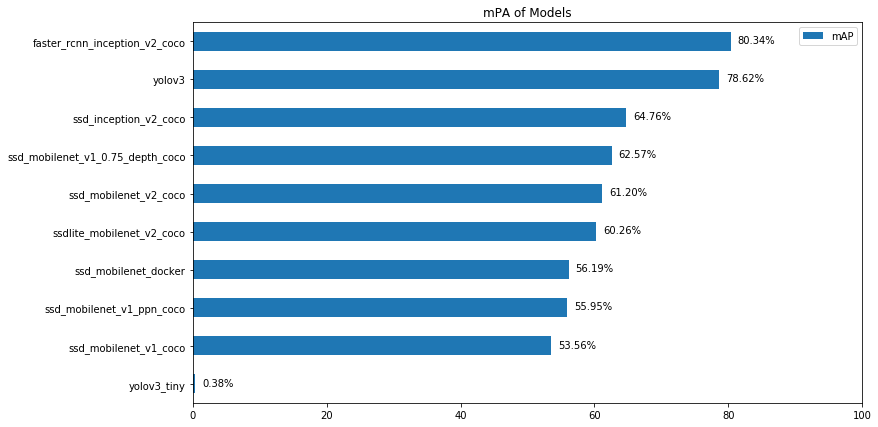

In [7]:
plot_side_bar(results,'model_name','mAP', 'mPA of Models',size = (12,7))

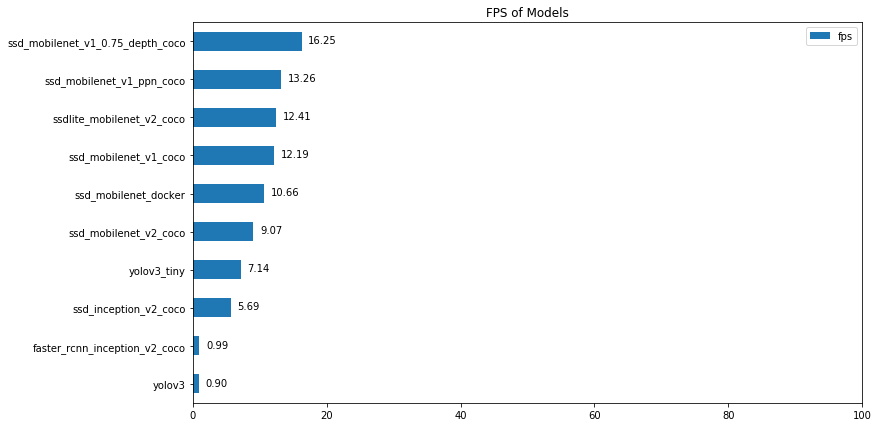

In [8]:
plot_side_bar(results,'model_name','fps', 'FPS of Models',size = (12,7), format_numb = "{:.2f}")

# Count People in frames

In [9]:
count_predict = models_prediteds.groupby(['model_name', 'frame_number']).count().iloc[:,0]
count_predict = pd.DataFrame(count_predict.reset_index())
count_predict.columns = ['model_name', 'frame_number', 'people']

count_real = ground_truth.groupby(['model_name', 'frame_number']).count().iloc[:,0]
count_real = pd.DataFrame(count_real.reset_index())
count_real.columns = ['model_name', 'frame_number', 'people']

count_predict.head()

,model_name,frame_number,people
0,faster_rcnn_inception_v2_coco,1.0,3
1,faster_rcnn_inception_v2_coco,2.0,3
2,faster_rcnn_inception_v2_coco,3.0,3
3,faster_rcnn_inception_v2_coco,4.0,3
4,faster_rcnn_inception_v2_coco,5.0,3


In [10]:
count_predict['error'] = get_error(count_predict, 'people', count_real, 'people')
count_predict['perc_error'] = get_perc_error(count_predict, 'people', count_real, 'people')

count_predict.to_csv('output/count_predict.csv')
count_real.to_csv('output/count_real.csv')

count_predict.sample(5)

,model_name,frame_number,people,error,perc_error
4817,ssd_mobilenet_v2_coco,48.0,5,1,0.166667
3162,ssd_mobilenet_v1_0.75_depth_coco,778.0,11,4,0.571429
3095,ssd_mobilenet_v1_0.75_depth_coco,711.0,10,2,0.250000
6239,ssdlite_mobilenet_v2_coco,675.0,6,1,0.142857
2678,ssd_mobilenet_v1_0.75_depth_coco,294.0,7,1,0.166667


In [11]:
mean_error = count_predict.groupby('model_name').mean().reset_index()[['model_name', 'error']]
results = results.join(mean_error.set_index('model_name'), 'model_name')

mean_error = count_predict.groupby('model_name').mean().reset_index()[['model_name', 'perc_error']]
results = results.join(mean_error.set_index('model_name'), 'model_name')


results.to_csv('output/results.csv')

In [12]:
results

,model_name,mAP,true_positive,false_positive,found,fps,error,perc_error
0,faster_rcnn_inception_v2_coco,80.34,4015,855,4870,0.993388,0.593711,0.100241
1,yolov3,78.62,4017,777,4794,0.900000,0.364780,0.067484
2,ssd_mobilenet_v1_coco,53.56,2847,622,3469,12.194021,1.598742,0.268916
3,ssd_mobilenet_v2_coco,61.20,3240,574,3814,9.074642,1.162264,0.192734
4,ssd_inception_v2_coco,64.76,3318,567,3885,5.689048,1.139623,0.191842
5,ssdlite_mobilenet_v2_coco,60.26,3236,725,3961,12.410751,1.037736,0.173911
6,ssd_mobilenet_v1_0.75_depth_coco,62.57,3494,2418,5912,16.254624,1.808805,0.337225
7,ssd_mobilenet_docker,56.19,2996,656,3652,10.657425,1.338365,0.221244
8,ssd_mobilenet_v1_ppn_coco,55.95,3128,1263,4391,13.260324,1.000000,0.173332
9,yolov3_tiny,0.38,297,4866,5163,7.142800,0.977358,0.187995


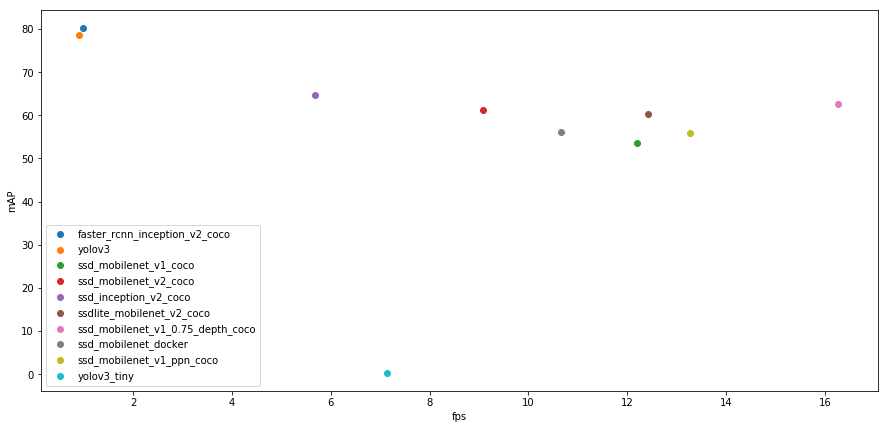

In [13]:
scatter_plot(results, models_names, 'fps', 'mAP', (15,7),'fps', y_label = 'mAP')

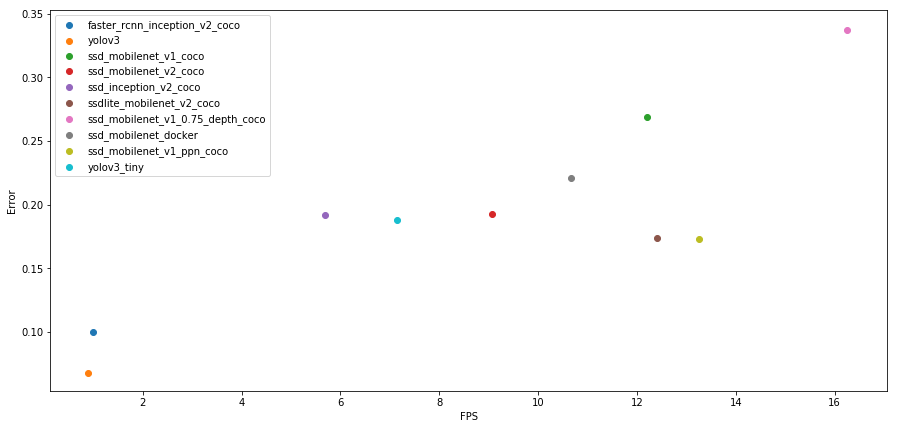

In [14]:
scatter_plot(results, models_names, 'fps', 'perc_error', (15,7),'FPS', 'Error')

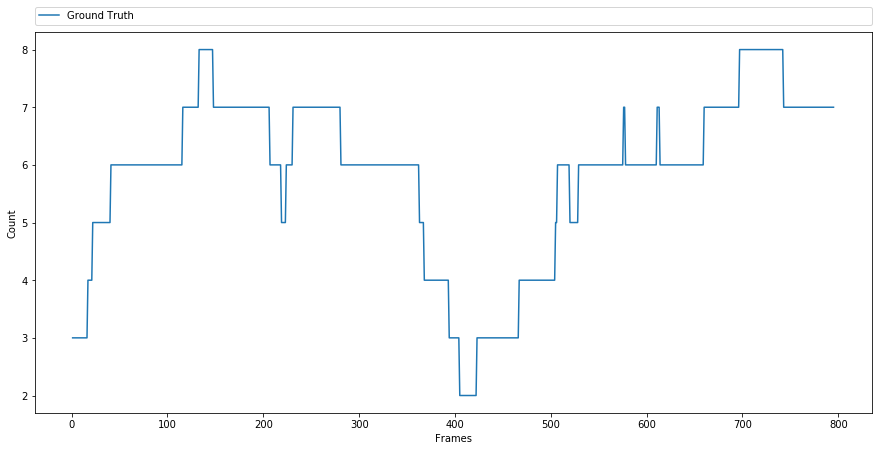

In [15]:
size = (15,7)
plt.figure(figsize=size)

plt.plot(count_real.set_index('frame_number')['people'], label = 'Ground Truth')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
     mode="expand", borderaxespad=0.)
plt.xlabel('Frames')
plt.ylabel('Count')
plt.show()

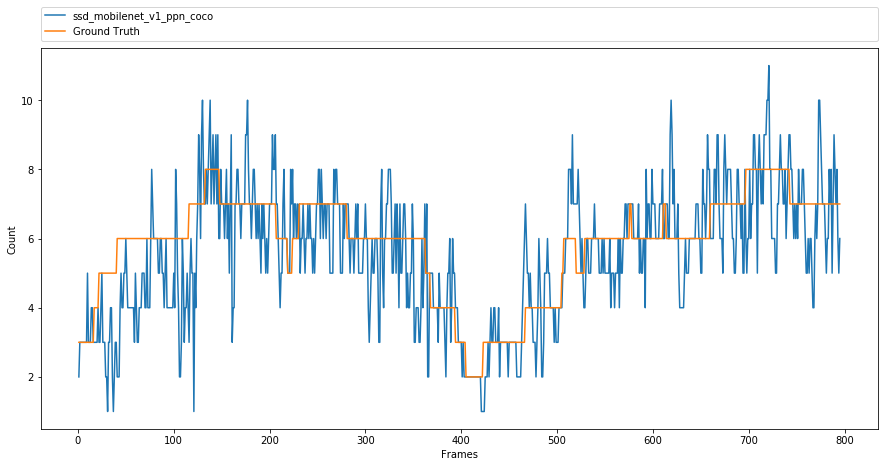

In [16]:
name_to_plot = 'ssd_mobilenet_v1_ppn_coco'
plot_counter(count_predict[count_predict['model_name']==name_to_plot],
             name_to_plot, count_real, 'frame_number', 'people', size = (15,7))

### Selected one model to specify the pos processing
Selected <strong>ssd_mobilenet_v1_ppn_coco</strong>. This model has the lowest error and a good prediction time

# Filter

In [17]:
ppn = count_predict[count_predict['model_name'] == name_to_plot].reset_index(drop = True)
ppn['time'] = ppn['frame_number']*1/13.26
ppn.head(2)

,model_name,frame_number,people,error,perc_error,time
0,ssd_mobilenet_v1_ppn_coco,1.0,2,1,0.333333,0.075415
1,ssd_mobilenet_v1_ppn_coco,2.0,3,0,0.000000,0.150830


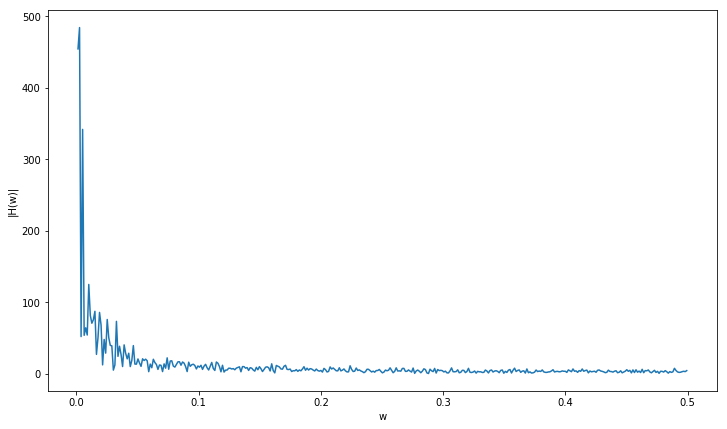

In [18]:
plot_freq(count_real, 'people')

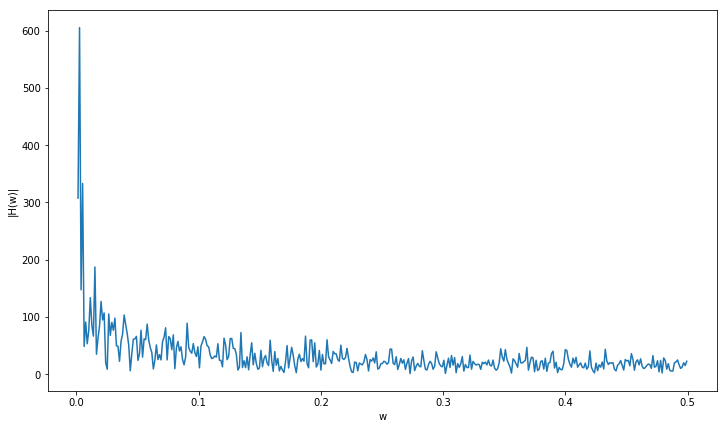

In [19]:
plot_freq(ppn, 'people')

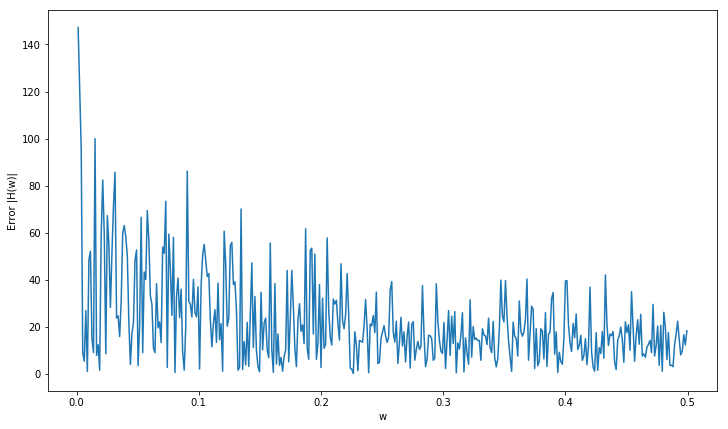

In [20]:
plot_freq_diff(count_real, ppn, 'people', 'people')

/home/angelo/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


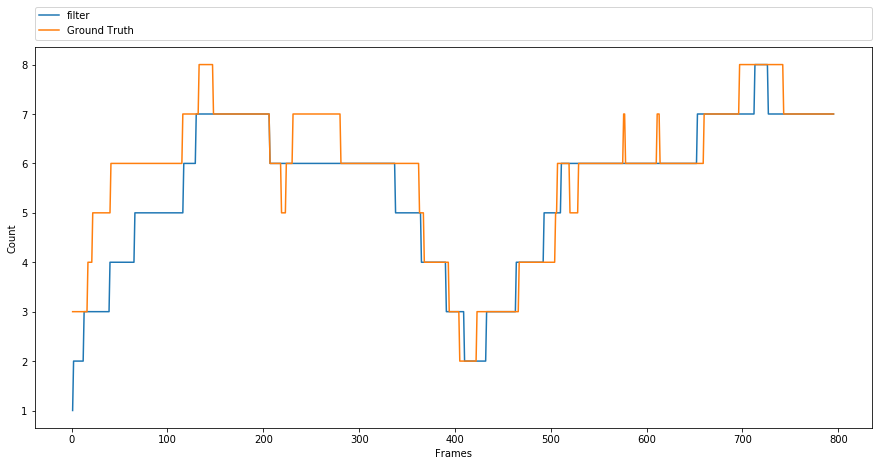

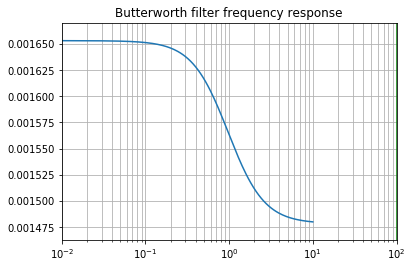

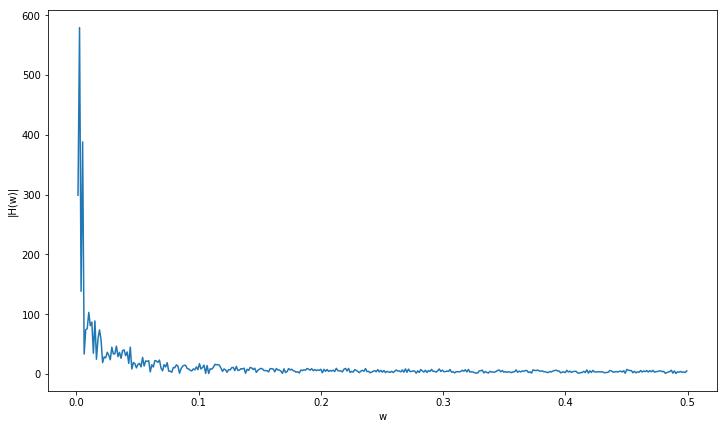

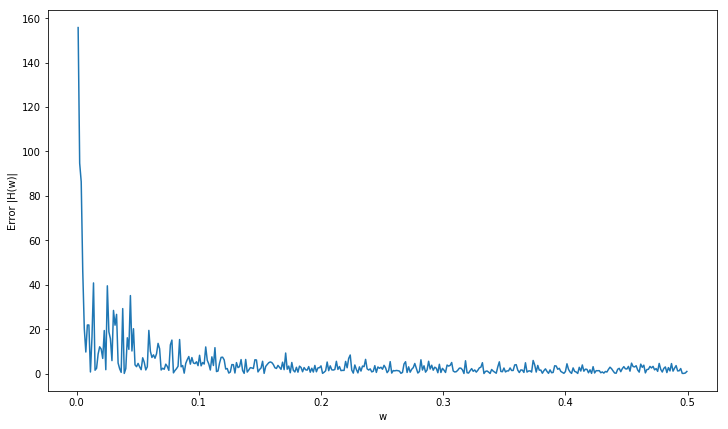

,model_name,error
0,ssd_mobilenet_v1_ppn_coco,0.450314


In [21]:
b, a = signal.butter(2, 1/0.05/795, 'low', analog=False)

y = signal.filtfilt(b, a, ppn['people'].values)
ppn['filter'] = np.round(y)
plot_counter(ppn,
             'filter', count_real, 'frame_number', ('filter','people'), size = (15,7))

w, h = signal.freqs(b, a)
plt.plot(w, abs(h))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
#plt.xlabel('Frequency [radians / second]')
#plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

plot_freq(ppn, 'filter')
plot_freq_diff(count_real, ppn, 'people', 'filter')

ppn['error'] = get_error(ppn, 'filter', count_real, 'people')
mean_error = ppn.groupby('model_name').mean().reset_index()[['model_name', 'error']]
mean_error

Export filter

In [22]:
count_error = ppn.join(count_real.set_index('frame_number'), on='frame_number', rsuffix='_true')
#count = count.drop('model_name_true', 1)

ppn.to_csv('output/ppn.csv')

In [23]:
ppn['perc_error'] = get_perc_error(ppn, 'filter', count_real, 'people')
mean_error = ppn.groupby('model_name').mean().reset_index()[['model_name', 'perc_error']]
mean_error

,model_name,perc_error
0,ssd_mobilenet_v1_ppn_coco,0.0824


In [24]:
count_error.to_csv('export.csv')